In [9]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)

In [10]:
# ============================================================
# Semi-Supervised Regular Functional Autoencoder (FAE)
# - Reconstruction loss + optional smoothness penalty
# - PLUS classification head after encoder rep with CE loss
# - Labels are used DURING training (semi-supervised)
# - Keeps history for plots every log_every epochs
# - Saves "extras" for latent/confusion/reconstruction plots
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from skfda import representation


# -------------------------
# 0) Reproducibility
# -------------------------
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# -------------------------
# 1) Basis construction
# -------------------------
def build_basis_fc(tpts, n_basis=20, basis_type="Bspline", custom_basis_fn=None):
    """
    Returns basis matrix evaluated on tpts.
    Output shape: [n_time, n_basis]
    """
    if custom_basis_fn is not None:
        B = custom_basis_fn(tpts)
        if not torch.is_tensor(B):
            B = torch.tensor(B, dtype=torch.float32)
        return B.float()

    t = tpts.flatten().detach().cpu().numpy()
    t_min, t_max = float(t.min()), float(t.max())

    if basis_type == "Bspline":
        basis = representation.basis.BSplineBasis(n_basis=n_basis, order=4)
        eval_ = basis(tpts.detach().cpu().numpy(), derivative=0)[:, :, 0]  # [n_time, n_basis]
    elif basis_type == "Fourier":
        basis = representation.basis.Fourier([t_min, t_max], n_basis=n_basis)
        eval_ = basis(tpts.detach().cpu().numpy(), derivative=0)[:, :, 0]
    else:
        raise ValueError("basis_type must be 'Bspline' or 'Fourier'")

    return torch.from_numpy(eval_).float()


# -------------------------
# 2) Dataset that returns (x, y)
# -------------------------
class XYDataset(Dataset):
    def __init__(self, X, y_idx):
        self.X = X
        self.y = torch.tensor(y_idx, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.y[i]


# -------------------------
# 3) FAE model + classifier head
# -------------------------
class SemiSupervisedFAE(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, n_classes=4, init_weight_sd=None):
        super().__init__()
        self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()  # linear FAE

        # classifier head: linear layer = multinomial logistic regression
        self.classifier = nn.Linear(n_rep, n_classes, bias=True)

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    def project(self, x, tpts, basis_fc):
        """
        x: [batch, n_time]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time]
        returns: [batch, n_basis]
        """
        t = tpts.flatten()
        dt = t[1:] - t[:-1]

        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # [n_time]

        n_time = x.shape[1]
        if basis_fc.shape[0] == n_time:
            B = basis_fc
        elif basis_fc.shape[1] == n_time:
            B = basis_fc.T
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_time={n_time}")

        return (x * W) @ B  # [batch, n_basis]

    def revert(self, coef, basis_fc):
        """
        coef: [batch, n_basis]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time]
        returns: [batch, n_time]
        """
        n_basis = coef.shape[1]
        if basis_fc.shape[1] == n_basis:
            return coef @ basis_fc.T
        elif basis_fc.shape[0] == n_basis:
            return coef @ basis_fc
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_basis={n_basis}")

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)
        rep = self.activation(self.encoder(feature))
        coef = self.decoder(rep)
        x_hat = self.revert(coef, basis_fc_revert)

        logits = self.classifier(rep)  # [batch, n_classes]
        return x_hat, rep, feature, coef, logits


# -------------------------
# 4) Penalty
# -------------------------
def diff_penalty(coef):
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))


# -------------------------
# 5) Train / evaluate
# -------------------------
def train_one_epoch_semi(
    model, loader, optimizer,
    recon_loss_fn, ce_loss_fn,
    device, tpts, basis_fc_project, basis_fc_revert,
    pen=None, lamb=0.0, alpha=1.0
):
    """
    alpha: weight for classification (CE) loss
    lamb:  weight for penalty
    """
    model.train()
    total = 0.0
    n_batches = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        x_hat, rep, feature, coef, logits = model(x_batch, tpts, basis_fc_project, basis_fc_revert)

        # reconstruction
        loss = recon_loss_fn(x_hat, x_batch)

        # penalty
        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        # classification
        loss = loss + alpha * ce_loss_fn(logits, y_batch)

        loss.backward()
        optimizer.step()

        total += float(loss.detach().cpu())
        n_batches += 1

    return total / max(n_batches, 1)


@torch.no_grad()
def evaluate_semi(model, X, y_idx, device, tpts, basis_fc_project, basis_fc_revert, recon_loss_fn):
    model.eval()
    X = X.to(device).float()
    y = torch.tensor(y_idx, dtype=torch.long, device=device)

    x_hat, rep, feature, coef, logits = model(X, tpts, basis_fc_project, basis_fc_revert)

    recon_loss = float(recon_loss_fn(x_hat, X).detach().cpu())
    pred = torch.argmax(logits, dim=1)
    acc = float((pred == y).float().mean().detach().cpu())

    return x_hat, rep, recon_loss, acc, coef


# -------------------------
# 6) Main runner (semi-supervised)
# -------------------------
def run_fae_experiment_semi(
    x, label, tpts,
    n_iter=1,
    split_rate=0.8,
    epochs=5000,
    batch_size=28,
    n_rep=5,
    n_basis_project=20,
    n_basis_revert=20,
    basis_type_project="Bspline",
    basis_type_revert="Bspline",
    custom_basis_project_fn=None,
    custom_basis_revert_fn=None,
    pen="diff",
    lamb=0.001,
    alpha=1.0,              # classification loss weight
    lr=1e-3,
    weight_decay=1e-6,
    init_weight_sd=0.5,
    log_every=100,
    device="cpu",
    seed=743,
    save_extras=True
):
    set_seed(seed)
    device = torch.device(device)

    # Map labels {1,2,3,4} -> {0,1,2,3}
    label = np.asarray(label)
    classes = np.sort(np.unique(label))
    class_to_idx = {c: i for i, c in enumerate(classes)}
    y_idx_all = np.array([class_to_idx[c] for c in label], dtype=int)
    n_classes = len(classes)

    # basis
    basis_fc_project = build_basis_fc(tpts, n_basis_project, basis_type_project, custom_basis_project_fn).to(device)
    basis_fc_revert  = build_basis_fc(tpts, n_basis_revert,  basis_type_revert,  custom_basis_revert_fn).to(device)
    tpts = tpts.to(device).float()

    recon_loss_fn = nn.MSELoss()
    ce_loss_fn = nn.CrossEntropyLoss()

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "train_class_acc": [],
        "test_class_acc": [],
        "per_epoch_test_recon_loss": [[] for _ in range(epochs // log_every)],
        "per_epoch_test_class_acc": [[] for _ in range(epochs // log_every)],
        "label_mapping": class_to_idx,  # so you remember the mapping
    }

    idx_all = np.arange(x.shape[0])

    for r in range(n_iter):
        idx_train, idx_test = train_test_split(
            idx_all,
            train_size=split_rate,
            random_state=seed + r,
            shuffle=True,
            stratify=y_idx_all
        )

        TrainData = x[idx_train]
        TestData  = x[idx_test]
        TrainY    = y_idx_all[idx_train]
        TestY     = y_idx_all[idx_test]

        train_loader = DataLoader(XYDataset(TrainData, TrainY), batch_size=batch_size, shuffle=True)

        model = SemiSupervisedFAE(n_basis_project, n_rep, n_basis_revert, n_classes=n_classes, init_weight_sd=init_weight_sd).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(1, epochs + 1):
            train_total_loss = train_one_epoch_semi(
                model, train_loader, optimizer,
                recon_loss_fn, ce_loss_fn,
                device, tpts, basis_fc_project, basis_fc_revert,
                pen=pen, lamb=lamb, alpha=alpha
            )

            if epoch % log_every == 0:
                _, reps_test, test_recon, test_acc, _ = evaluate_semi(
                    model, TestData, TestY, device, tpts, basis_fc_project, basis_fc_revert, recon_loss_fn
                )
                _, reps_train, train_recon, train_acc, _ = evaluate_semi(
                    model, TrainData, TrainY, device, tpts, basis_fc_project, basis_fc_revert, recon_loss_fn
                )

                k = (epoch // log_every) - 1
                history["per_epoch_test_recon_loss"][k].append(test_recon)
                history["per_epoch_test_class_acc"][k].append(test_acc)

                print(f"[rep {r+1}/{n_iter}] epoch {epoch:4d} | recon_train={train_recon:.4f} | recon_test={test_recon:.4f} | test_acc={test_acc:.4f}")

        # final evaluation
        _, _, test_recon, test_acc, _ = evaluate_semi(model, TestData, TestY, device, tpts, basis_fc_project, basis_fc_revert, recon_loss_fn)
        _, _, train_recon, train_acc, _ = evaluate_semi(model, TrainData, TrainY, device, tpts, basis_fc_project, basis_fc_revert, recon_loss_fn)

        history["train_recon_loss"].append(train_recon)
        history["test_recon_loss"].append(test_recon)
        history["train_class_acc"].append(train_acc)
        history["test_class_acc"].append(test_acc)

        print(f"Replicate {r+1} complete.\n")

        if save_extras and (r == n_iter - 1):
            history["extras"] = {
                "model": model,
                "TrainData": TrainData,
                "TestData": TestData,
                "TrainY": TrainY,
                "TestY": TestY,
                "tpts": tpts,
                "basis_fc_project": basis_fc_project,
                "basis_fc_revert": basis_fc_revert,
                "device": device,
                "recon_loss_fn": recon_loss_fn,
                "classes_original": classes,
                "label_mapping": class_to_idx
            }

    return history

In [24]:
history = run_fae_experiment_semi(
    x=x,
    label=label,
    tpts=tpts,
    n_iter=1,
    epochs=3000,
    log_every=100,
    alpha=1.0,      # weight of classification loss (we can try 0.1, 1.0, 5.0)
    lamb=0.001      # smoothness penalty parameter
)

[rep 1/1] epoch  100 | recon_train=0.3217 | recon_test=0.3023 | test_acc=0.8036
[rep 1/1] epoch  200 | recon_train=0.2120 | recon_test=0.1998 | test_acc=0.8929
[rep 1/1] epoch  300 | recon_train=0.1211 | recon_test=0.1129 | test_acc=0.8929
[rep 1/1] epoch  400 | recon_train=0.0803 | recon_test=0.0736 | test_acc=0.8929
[rep 1/1] epoch  500 | recon_train=0.0668 | recon_test=0.0616 | test_acc=0.8929
[rep 1/1] epoch  600 | recon_train=0.0609 | recon_test=0.0574 | test_acc=0.8929
[rep 1/1] epoch  700 | recon_train=0.0551 | recon_test=0.0533 | test_acc=0.8929
[rep 1/1] epoch  800 | recon_train=0.0470 | recon_test=0.0478 | test_acc=0.9107
[rep 1/1] epoch  900 | recon_train=0.0391 | recon_test=0.0422 | test_acc=0.9464
[rep 1/1] epoch 1000 | recon_train=0.0338 | recon_test=0.0381 | test_acc=0.9464
[rep 1/1] epoch 1100 | recon_train=0.0309 | recon_test=0.0358 | test_acc=1.0000
[rep 1/1] epoch 1200 | recon_train=0.0296 | recon_test=0.0347 | test_acc=1.0000
[rep 1/1] epoch 1300 | recon_train=0.029

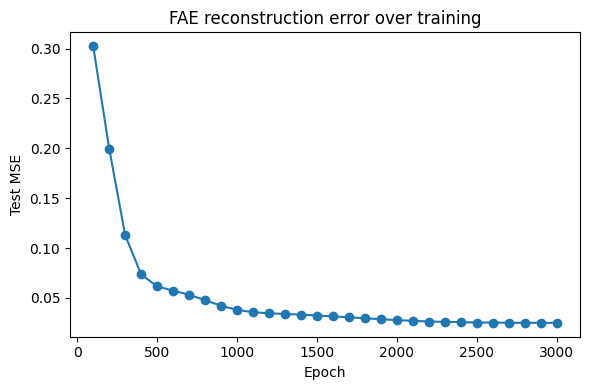

In [25]:
import numpy as np
import matplotlib.pyplot as plt

test_mse_mean = [np.mean(v) for v in history["per_epoch_test_recon_loss"]]
test_mse_sd   = [np.std(v)  for v in history["per_epoch_test_recon_loss"]]

epochs_grid = np.arange(1, len(test_mse_mean)+1) * 100

plt.figure(figsize=(6,4))
plt.errorbar(epochs_grid, test_mse_mean, yerr=test_mse_sd, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test MSE")
plt.title("FAE reconstruction error over training")
plt.tight_layout()
plt.show()

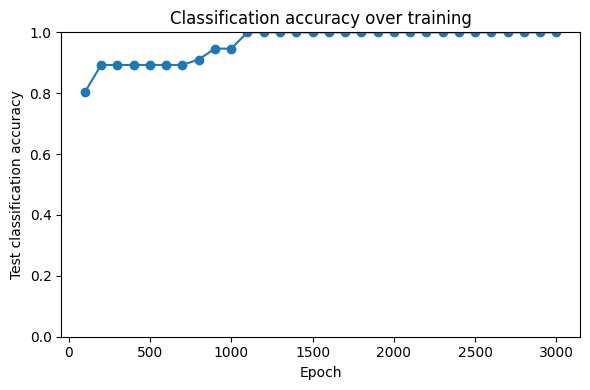

In [26]:
test_acc_mean = [np.mean(v) for v in history["per_epoch_test_class_acc"]]
test_acc_sd   = [np.std(v)  for v in history["per_epoch_test_class_acc"]]

plt.figure(figsize=(6,4))
plt.errorbar(epochs_grid, test_acc_mean, yerr=test_acc_sd, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Test classification accuracy")
plt.ylim(0, 1)
plt.title("Classification accuracy over training")
plt.tight_layout()
plt.show()

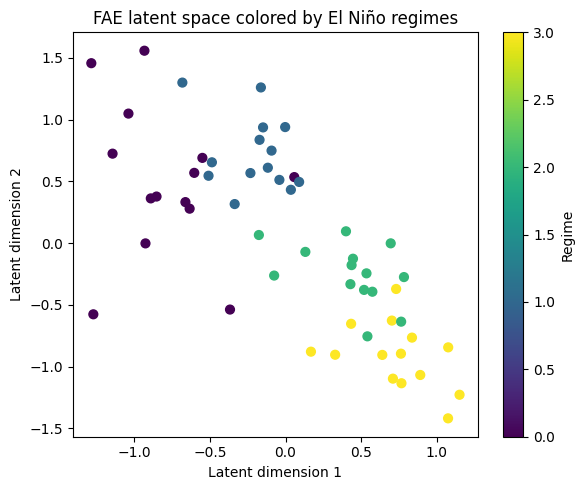

In [27]:
extras = history["extras"]
model = extras["model"]
TestData = extras["TestData"]
TestY = extras["TestY"]

model.eval()
with torch.no_grad():
    _, reps, _, _, _ = model(
        TestData.to(extras["device"]).float(),
        extras["tpts"],
        extras["basis_fc_project"],
        extras["basis_fc_revert"]
    )

z = reps.cpu().numpy()

plt.figure(figsize=(6,5))
scatter = plt.scatter(z[:,0], z[:,1], c=TestY, cmap="viridis", s=40)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("FAE latent space colored by El Niño regimes")
cbar = plt.colorbar(scatter)
cbar.set_label("Regime")
plt.tight_layout()
plt.show()

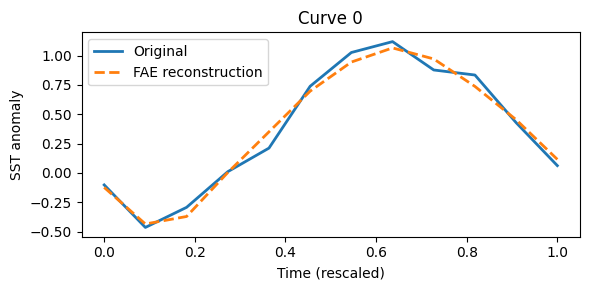

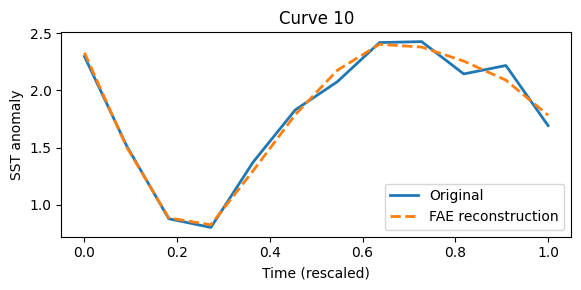

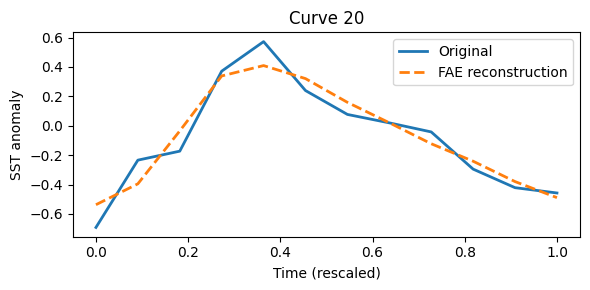

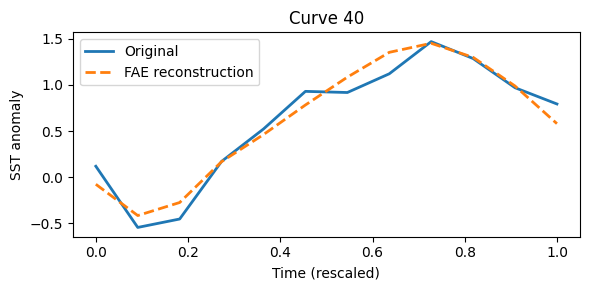

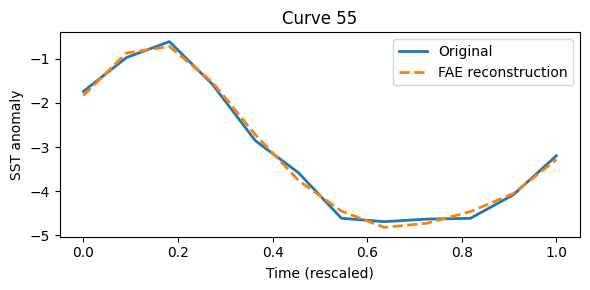

In [28]:
import matplotlib.pyplot as plt

t = extras["tpts"].cpu().numpy().flatten()

model.eval()
with torch.no_grad():
    FAE_pred, _, _, _, _ = model(
        extras["TestData"].to(extras["device"]).float(),
        extras["tpts"],
        extras["basis_fc_project"],
        extras["basis_fc_revert"]
    )

idx_list = [0, 10, 20, 40, 55]

for i in idx_list:
    plt.figure(figsize=(6,3))
    plt.plot(t, extras["TestData"][i].cpu().numpy(),
             label="Original", lw=2)
    plt.plot(t, FAE_pred[i].cpu().numpy(),
             "--", label="FAE reconstruction", lw=2)
    plt.xlabel("Time (rescaled)")
    plt.ylabel("SST anomaly")
    plt.title(f"Curve {i}")
    plt.legend()
    plt.tight_layout()
    plt.show()

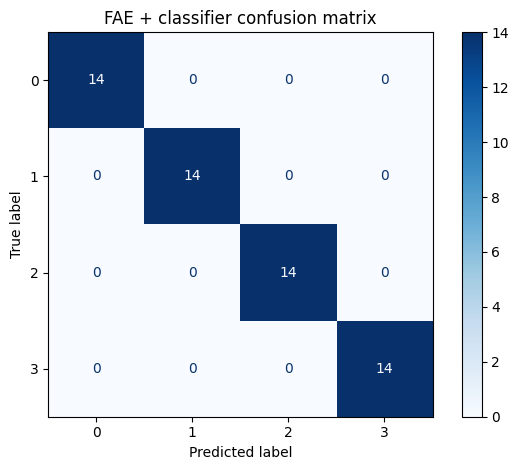

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with torch.no_grad():
    _, _, _, _, logits = model(
        extras["TestData"].to(extras["device"]).float(),
        extras["tpts"],
        extras["basis_fc_project"],
        extras["basis_fc_revert"]
    )

y_pred = torch.argmax(logits, dim=1).cpu().numpy()
cm = confusion_matrix(extras["TestY"], y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("FAE + classifier confusion matrix")
plt.tight_layout()
plt.show()


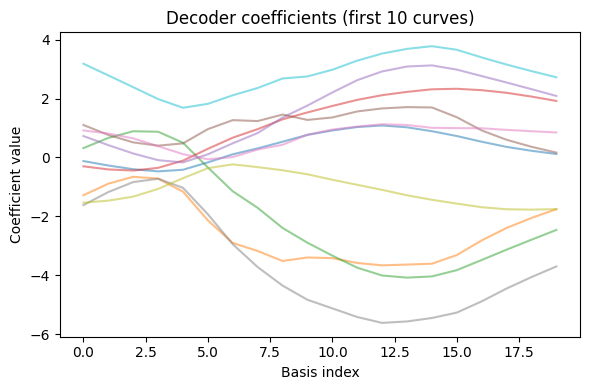

In [30]:
with torch.no_grad():
    _, _, _, coef, _ = model(
        extras["TestData"].to(extras["device"]).float(),
        extras["tpts"],
        extras["basis_fc_project"],
        extras["basis_fc_revert"]
    )

plt.figure(figsize=(6,4))
plt.plot(coef[:10].cpu().numpy().T, alpha=0.5)
plt.xlabel("Basis index")
plt.ylabel("Coefficient value")
plt.title("Decoder coefficients (first 10 curves)")
plt.tight_layout()
plt.show()
